<a href="https://colab.research.google.com/github/mutabazichristian/pipeline/blob/main/Task_3_Database_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import necessary package

import requests
import numpy as np
import joblib
import time
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Check if the API is running
health_url = "https://pipeline-databasedesign.onrender.com"

response = requests.get(health_url)

print("Status Code:", response.status_code)
print("Response Body:", response.json())

Status Code: 200
Response Body: {'message': 'Movie API is running'}


### Fetching the latest entry

In [3]:
def fetch_latest_movie():
    # Endpoint that returns all movies
    movies_url = "https://pipeline-databasedesign.onrender.com/movies/"

    # Make a GET request
    response = requests.get(movies_url)

    # Check for successful response
    if response.status_code == 200:
        movies = response.json()

        if not movies:
            print("No movies found in the database.")
            return None

        # Find the movie with the highest movie_id (latest entry)
        latest_movie = max(movies, key=lambda m: m['movie_id'])

        print(f"Latest Movie Retrieved:\nTitle: {latest_movie['title']}\nMovie ID: {latest_movie['movie_id']}")
        return latest_movie

    else:
        print(f"Failed to fetch movies. Status code: {response.status_code}")
        return None

# Run the function and get the latest movie
latest_movie = fetch_latest_movie()

Latest Movie Retrieved:
Title: Watchmen
Movie ID: 152


### Preprocess the data for prediction

In [5]:
path = "/content/data/movies.csv"
df = pd.read_csv(path)

# Print some part of the dataset
df.head()

,Rank,Title,Year,Score,Metascore,Genre,Vote,Director,Runtime,Revenue,Description
0,1,The Shawshank Redemption,1994,9.3,80.0,Drama,2011509,Frank Darabont,142,28.34,Two imprisoned men bond over a number of years...
1,2,The Dark Knight,2008,9.0,84.0,"Action, Crime, Drama",1980200,Christopher Nolan,152,534.86,When the menace known as the Joker emerges fro...
2,3,Inception,2010,8.8,74.0,"Action, Adventure, Sci-Fi",1760209,Christopher Nolan,148,292.58,A thief who steals corporate secrets through t...
3,4,Fight Club,1999,8.8,66.0,Drama,1609459,David Fincher,139,37.03,An insomniac office worker and a devil-may-car...
4,5,Pulp Fiction,1994,8.9,94.0,"Crime, Drama",1570194,Quentin Tarantino,154,107.93,"The lives of two mob hitmen, a boxer, a gangst..."


In [6]:
# Display basic info to check for missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rank         10000 non-null  int64  
 1   Title        10000 non-null  object 
 2   Year         10000 non-null  int64  
 3   Score        10000 non-null  float64
 4   Metascore    6781 non-null   float64
 5   Genre        10000 non-null  object 
 6   Vote         10000 non-null  int64  
 7   Director     9999 non-null   object 
 8   Runtime      10000 non-null  int64  
 9   Revenue      7473 non-null   float64
 10  Description  10000 non-null  object 
dtypes: float64(3), int64(4), object(4)
memory usage: 859.5+ KB


In [7]:
# Fill missing numerical values
df['Score'] = df['Score'].fillna(0)
df['Metascore'] = df['Metascore'].fillna(50)
df['Vote'] = df['Vote'].fillna(0)
df['Runtime'] = df['Runtime'].fillna(df['Runtime'].mean())  # Or 90
df['Revenue'] = df['Revenue'].fillna(0)

# Create a target variable: High Revenue (1) if Revenue > 100, else 0
df['high_revenue'] = df['Revenue'].apply(lambda x: 1 if x > 100 else 0)

# Select feature columns
feature_columns = ['Score', 'Metascore', 'Vote', 'Runtime']
X = df[feature_columns]
y = df['high_revenue']

# Preview processed data
X.head(), y.head()

(   Score  Metascore     Vote  Runtime
 0    9.3       80.0  2011509      142
 1    9.0       84.0  1980200      152
 2    8.8       74.0  1760209      148
 3    8.8       66.0  1609459      139
 4    8.9       94.0  1570194      154,
 0    0
 1    1
 2    1
 3    0
 4    1
 Name: high_revenue, dtype: int64)

<Axes: xlabel='high_revenue'>

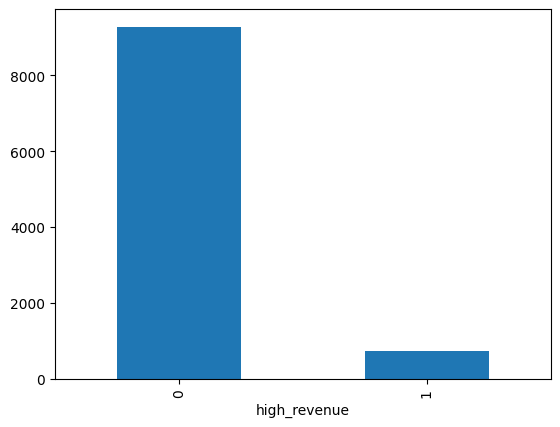

In [9]:
df['high_revenue'].value_counts().plot(kind='bar')

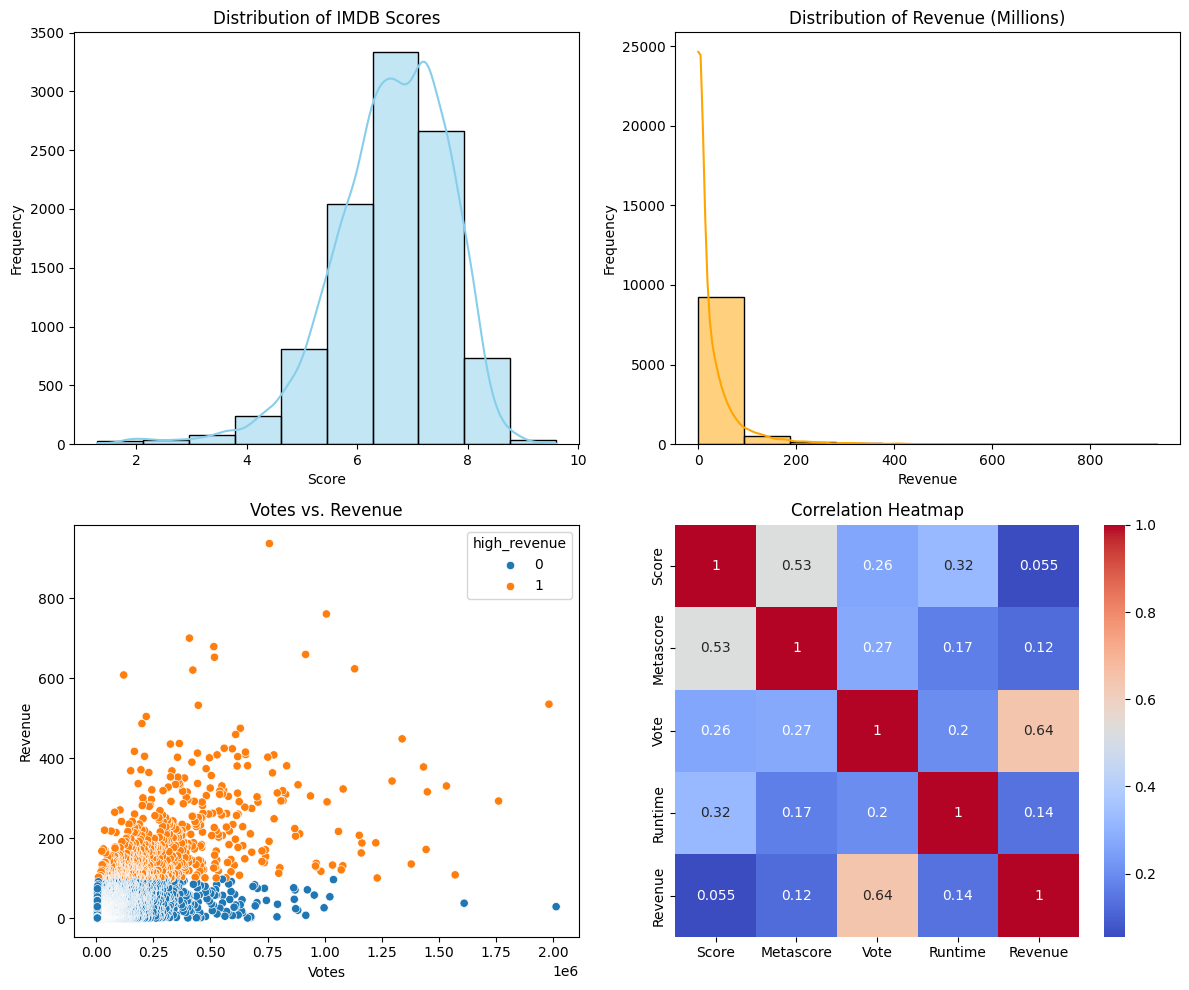

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid with consistent size

# Distribution of Scores
sns.histplot(df['Score'], kde=True, bins=10, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of IMDB Scores')
axes[0, 0].set_xlabel('Score')
axes[0, 0].set_ylabel('Frequency')

# Distribution of Revenue
sns.histplot(df['Revenue'], kde=True, bins=10, color='orange', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Revenue (Millions)')
axes[0, 1].set_xlabel('Revenue')
axes[0, 1].set_ylabel('Frequency')

# Votes vs. Revenue scatter plot
sns.scatterplot(x='Vote', y='Revenue', data=df, hue='high_revenue', ax=axes[1, 0])
axes[1, 0].set_title('Votes vs. Revenue')
axes[1, 0].set_xlabel('Votes')
axes[1, 0].set_ylabel('Revenue')

# Correlation heatmap
corr = df[['Score', 'Metascore', 'Vote', 'Runtime', 'Revenue']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axes[1, 1])
axes[1, 1].set_title('Correlation Heatmap')

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

### Train ML Model on Movie Data

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# Create the directory if it doesn't exist
os.makedirs("saved_models", exist_ok=True)

# Now save the model
joblib.dump(model, 'saved_models/movie_model.pkl')

['saved_models/movie_model.pkl']

In [13]:
print("Model trained and saved as 'movie_model.pkl'")

Model trained and saved as 'movie_model.pkl'


Text(0.5, 1.0, 'Feature Importance')

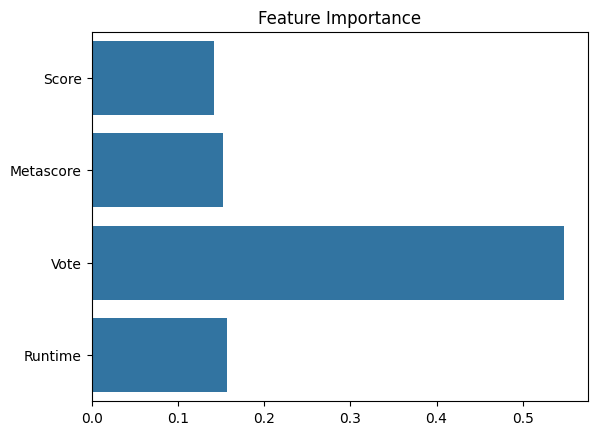

In [14]:
sns.barplot(x=model.feature_importances_, y=feature_columns)
plt.title('Feature Importance')

The number of votes (likely user votes or ratings) is the strongest predictor of whether a movie will achieve high or low revenue

Cross-validation Accuracy: 0.5760
Classification Report:
               precision    recall  f1-score   support

 Low Revenue       0.96      0.98      0.97      1852
High Revenue       0.67      0.47      0.56       148

    accuracy                           0.94      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.94      0.94      0.94      2000

Accuracy: 0.9440
Precision: 0.6731
Recall: 0.4730
F1 Score: 0.5556

Confusion Matrix:
 [[1818   34]
 [  78   70]]


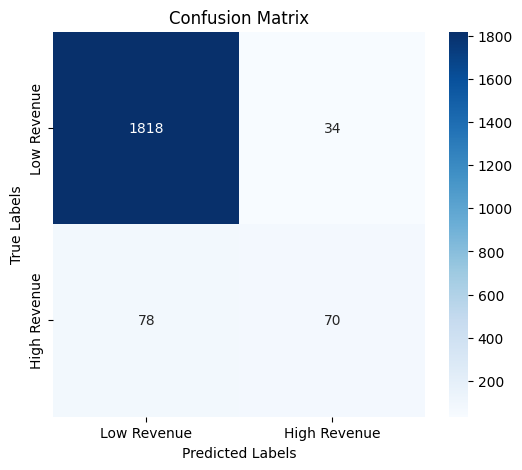

In [16]:
# Predict class labels
y_pred = model.predict(X_test)

cross_val = cross_val_score(model, X, y, cv=5)
print(f"Cross-validation Accuracy: {cross_val.mean():.4f}")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Low Revenue', 'High Revenue']))

# Model Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
class_names = ['Low Revenue', 'High Revenue']  # Define class labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Make predictions

In [17]:
# Fetch the Latest Entry
def fetch_latest_movie():
    response = requests.get("https://pipeline-databasedesign.onrender.com/movies/")
    if response.status_code == 200:
        movies = response.json()
        if movies:
            return max(movies, key=lambda x: x['movie_id'])  # Get latest by movie_id
    return None

latest_movie = fetch_latest_movie()
if latest_movie:
    print(f"Latest movie fetched successfully!")
    print(f"Movie Title: {latest_movie['title']}, Movie ID: {latest_movie['movie_id']}")
else:
    print("No movie data found.")

Latest movie fetched successfully!
Movie Title: Watchmen, Movie ID: 152


In [18]:
# Preprocess Data
def preprocess_movie_data(movie):
    feature_mapping = {
        'score': 'Score',
        'metascore': 'Metascore',
        'votes': 'Vote',
        'runtime': 'Runtime'
    }

    # Rename keys using mapping
    movie = {feature_mapping.get(k, k): v for k, v in movie.items()}

    feature_columns = ['Score', 'Metascore', 'Vote', 'Runtime']
    movie_df = pd.DataFrame([movie])

    # Ensure only required columns are selected
    movie_df = movie_df[feature_columns]

    # Handle missing values
    movie_df['Score'] = movie_df['Score'].fillna(0)
    movie_df['Metascore'] = movie_df['Metascore'].fillna(50)
    movie_df['Vote'] = movie_df['Vote'].fillna(0)
    movie_df['Runtime'] = movie_df['Runtime'].fillna(movie_df['Runtime'].mean())

    return movie_df

# Run preprocessing and print the processed DataFrame
if latest_movie:
    processed_movie = preprocess_movie_data(latest_movie)
    print("Processed Movie Data:\n", processed_movie)

Processed Movie Data:
    Score  Metascore    Vote  Runtime
0    7.6         56  440466      162


In [19]:
# Load the trained model
model = joblib.load('saved_models/movie_model.pkl')
print("Model loaded successfully!")

Model loaded successfully!


In [20]:
# Make Prediction
def predict_movie_success(movie):
    processed_movie = preprocess_movie_data(movie)
    prediction = model.predict(processed_movie)
    return prediction[0]

if latest_movie:
    prediction = predict_movie_success(latest_movie)
    print(f"Predicted Revenue Class: {prediction}")

Predicted Revenue Class: 1


The model is using the features (Score, Metascore, Vote, and Runtime) for the movie "Watchmen" as inputs

**Predicted Revenue Class: 1:** Based on the processed data, the model predicts that this movie falls into Class 1 for revenue

In [21]:
# Check prediction probabilities (if supported by the model)
prediction_prob = model.predict_proba(processed_movie)
print("Prediction Probabilities:", prediction_prob)

Prediction Probabilities: [[0.23 0.77]]


The model is 77% confident that the movie "Watchmen" belongs to Class 1 (predicted class), which indicates a stronger likelihood that the movie falls into the Class 1 revenue category.

The remaining 23% is the model's confidence in Class 0.

### Logging Prediction Result Back to Database (Prediction Logging)

In [22]:
# Save Prediction Back to DB with all fields
def save_prediction(movie, prediction):
    update_url = f"https://pipeline-databasedesign.onrender.com/movies/{movie['movie_id']}"

    # Ensure prediction is serializable (convert to a standard integer)
    prediction = int(prediction)  # Convert to a standard integer

    # Prepare the data with all relevant fields
    data = {
        "movie_id": movie["movie_id"],
        "title": movie["title"],
        "year": movie.get("year"),  # use .get() to avoid KeyError if missing
        "score": movie.get("score"),
        "metascore": movie.get("metascore"),
        "votes": movie.get("votes"),
        "director_id": movie.get("director_id"),
        "runtime": movie.get("runtime"),
        "revenue": movie.get("revenue"),
        "description": movie.get("description"),
        "prediction": prediction  # Include the prediction
    }

    response = requests.put(update_url, json=data)

    # Print response details for debugging
    print("Response Status Code:", response.status_code)
    print("Response Text:", response.text)

    if response.status_code == 200:
        print("Prediction saved!")
    else:
        print("Error saving prediction.")

if latest_movie:
    save_prediction(latest_movie, prediction)

Response Status Code: 200
Response Text: {"movie_id":152,"title":"Watchmen","year":2009,"score":7.6,"metascore":56,"votes":440466,"director_id":50,"runtime":162,"revenue":107.51,"description":"In 1985 where former superheroes exist, the murder of a colleague sends active vigilante Rorschach into his own sprawling investigation, uncovering something that could completely change the course of history as we know it."}
Prediction saved!
